#PREDICCIÓN DEL CONSUMO TOTAL DE NAFTAS EN ARGENTINA PARA EL AÑO 2024


###Variables consideradas: Total km3 (cantidades vendidas historicas), Inflación anual historica, Precio Promedio Barril (OPEP),PBI de Argentina historico.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error,  make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from timeit import default_timer as timer
import warnings

warnings.filterwarnings("ignore")

In [ ]:
ruta_archivo = '/content/resumen 1989-2023.xls'
#hoja especfica
nombre_hoja = 'Comparativa total'

# hoja específica del archivo Excel
datos = pd.read_excel(ruta_archivo, sheet_name=nombre_hoja)

In [ ]:
datos.head(5)

,Año,Total km3,Inflacion%,Precio promedio/barill USD OPEP,PBI USD
0,1989,5064.940,30.7981,17.31,7.662966e+10
1,1990,5208.841,23.1396,22.26,1.413527e+11
2,1991,5830.385,1.7167,18.62,1.897200e+11
3,1992,6302.577,0.2490,18.44,2.287789e+11
4,1993,6465.291,0.1061,16.33,2.367417e+11


In [ ]:
datos['Inflacion%']=datos['Inflacion%']*100

In [ ]:
datos.head()

,Año,Total km3,Inflacion%,Precio promedio/barill USD OPEP,PBI USD
0,1989,5064.940,3079.81,17.31,7.662966e+10
1,1990,5208.841,2313.96,22.26,1.413527e+11
2,1991,5830.385,171.67,18.62,1.897200e+11
3,1992,6302.577,24.90,18.44,2.287789e+11
4,1993,6465.291,10.61,16.33,2.367417e+11


In [ ]:
datos.set_index('Año',inplace=True)

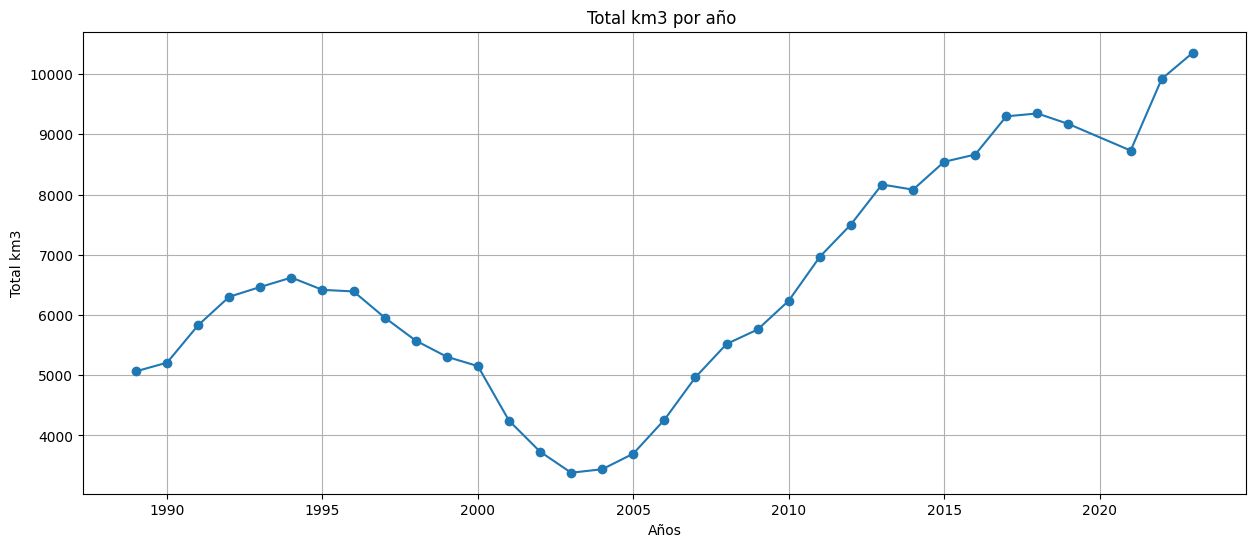

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(datos.index, datos['Total km3'], marker='o', linestyle='-')

# Agregar etiquetas y título
plt.xlabel('Años')
plt.ylabel('Total km3')
plt.title('Total km3 por año ')

# Mostrar el gráfico
plt.grid(True)
plt.show()

El año 2020 fue eliminado a fines de no distorsionar el análisis

In [ ]:
datos.head()

,Total km3,Inflacion%,Precio promedio/barill USD OPEP,PBI USD
Año,,,,
1989,5064.940,3079.81,17.31,7.662966e+10
1990,5208.841,2313.96,22.26,1.413527e+11
1991,5830.385,171.67,18.62,1.897200e+11
1992,6302.577,24.90,18.44,2.287789e+11
1993,6465.291,10.61,16.33,2.367417e+11


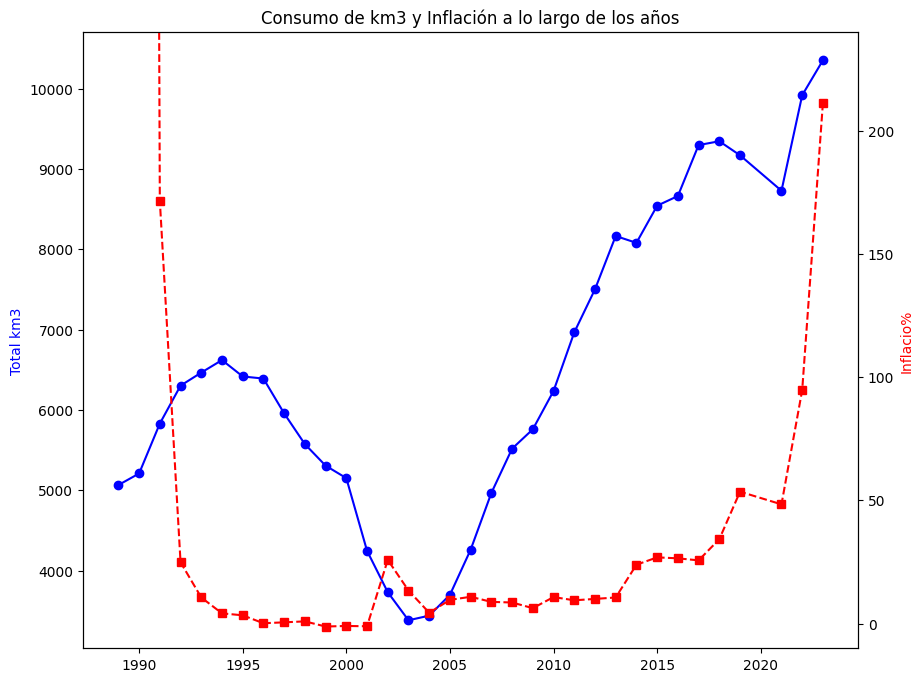

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,8))

#  total de km³ consumidos en el primer eje y
ax1.plot(datos.index, datos['Total km3'], color='b', marker='o', linestyle='-')
ax1.set_ylabel('Total km3', color='b')

# segundo eje y para la inflación
ax2 = ax1.twinx()
ax2.plot(datos.index, datos['Inflacion%'], color='r', marker='s', linestyle='--')
ax2.set_ylabel('Inflacio%', color='r')

# Establecer límites de la escala para el eje y de la inflación
ax2.set_ylim(-10, 240)  # Por ejemplo, establece el rango de 0 a 100 para la inflación

# Etiquetas y título
plt.xlabel('Años')
plt.title('Consumo de km3 y Inflación a lo largo de los años')

plt.show()


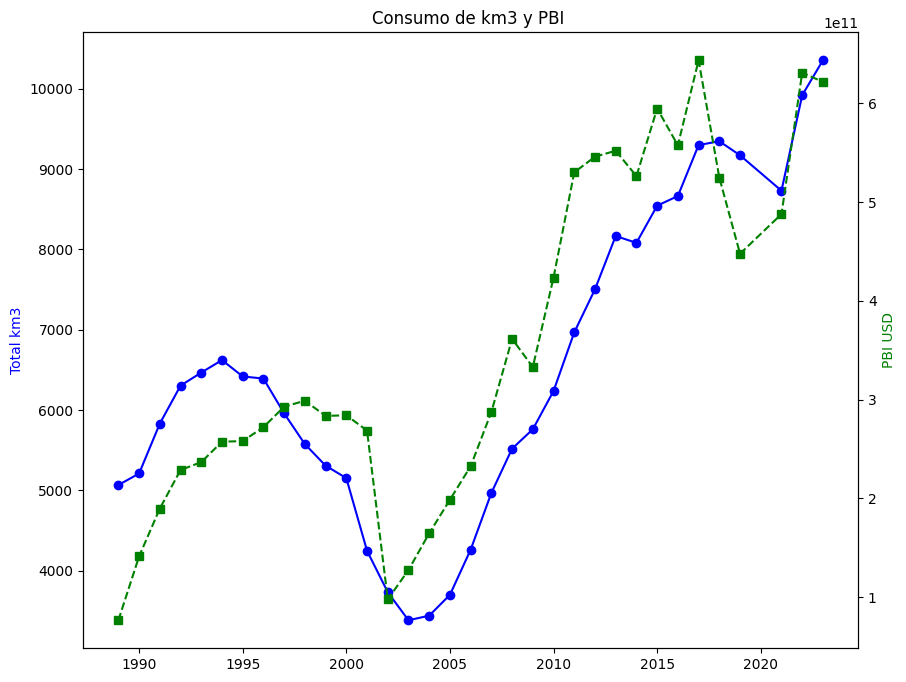

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,8))

#  total de km³ consumidos en el primer eje y
ax1.plot(datos.index, datos['Total km3'], color='b', marker='o', linestyle='-')
ax1.set_ylabel('Total km3', color='b')

# segundo eje y para la inflación
ax2 = ax1.twinx()
ax2.plot(datos.index, datos['PBI USD'], color='g', marker='s', linestyle='--')
ax2.set_ylabel('PBI USD', color='g')

# Etiquetas y título
plt.xlabel('Años')
plt.title('Consumo de km3 y PBI ')

plt.show()

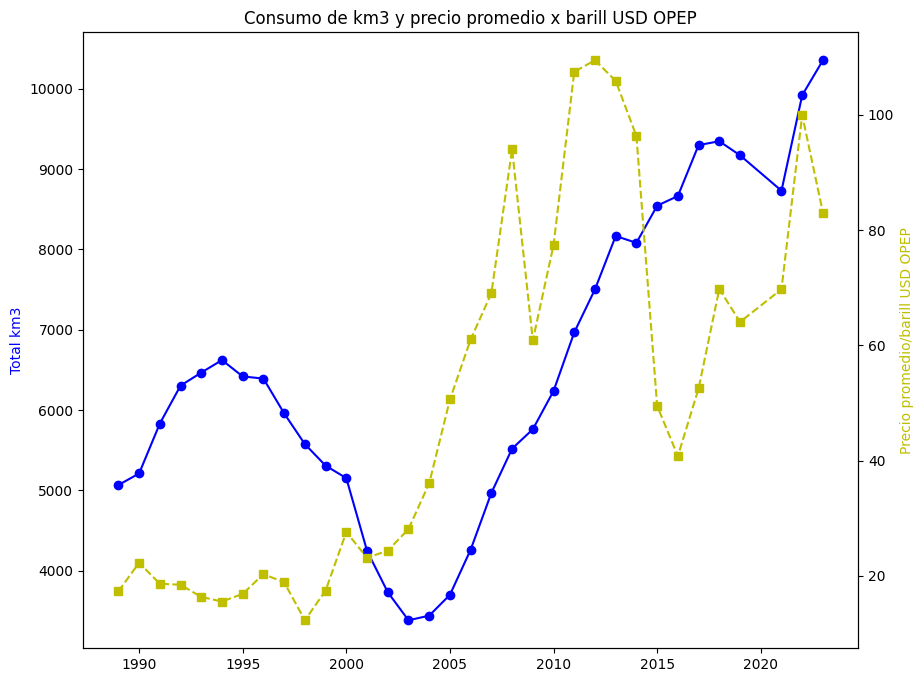

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,8))

#  total de km³ consumidos en el primer eje y
ax1.plot(datos.index, datos['Total km3'], color='b', marker='o', linestyle='-')
ax1.set_ylabel('Total km3', color='b')

# segundo eje y para la inflación
ax2 = ax1.twinx()
ax2.plot(datos.index, datos['Precio promedio/barill USD OPEP'], color='y', marker='s', linestyle='--')
ax2.set_ylabel('Precio promedio/barill USD OPEP', color='y')

# Etiquetas y título
plt.xlabel('Años')
plt.title('Consumo de km3 y precio promedio x barill USD OPEP')

plt.show()

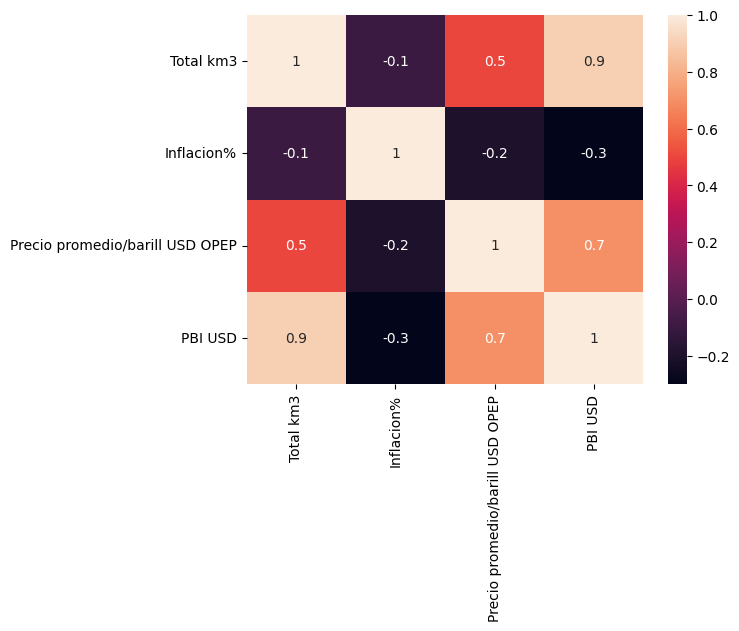

In [ ]:
matriz_correlacion= datos.corr().round(1)
sns.heatmap(data=matriz_correlacion, annot=True)
plt.show()

In [ ]:
def forward_selection(data, target, significancia):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significancia):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [ ]:
x=datos.drop('Total km3',axis=1)
y=datos['Total km3']

In [ ]:
significancia = 0.2
seleccionadas = forward_selection(x,y,significancia)
print(f"\nCon nivel {significancia} se han seleccionado {len(seleccionadas)} características: ",seleccionadas, '\n')


Con nivel 0.2 se han seleccionado 3 características:  ['PBI USD', 'Precio promedio/barill USD OPEP', 'Inflacion%'] 



<ipython-input-15-edcd23424107>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-15-edcd23424107>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-15-edcd23424107>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-15-edcd23424107>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


In [ ]:
# 1 )Preparación de datos
X = datos[['PBI USD','Inflacion%','Precio promedio/barill USD OPEP']]
y= datos['Total km3']

In [ ]:
# 2) Separacion en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Entrenamiento del modelo
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [ ]:
#Realizando las predicciones
y_pred = regressor.predict(X_test)
y_pred

array([ 4091.46141595,  5658.60390305,  9678.62897644, 10023.80007024,
        6322.02364569,  8150.49324945,  6924.57824421])

In [ ]:
y_test

Año
2004    3438.599610
2008    5518.147950
2016    8664.218396
2015    8543.538424
1997    5957.222000
2013    8166.294771
2010    6236.357891
Name: Total km3, dtype: float64

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df['Sesgo']=df.Actual -df.Predicted
df['Error_porc']=((df.Actual -df.Predicted)/df.Actual) *100
df

,Actual,Predicted,Sesgo,Error_porc
Año,,,,
2004,3438.599610,4091.461416,-652.861806,-18.986270
2008,5518.147950,5658.603903,-140.455953,-2.545346
2016,8664.218396,9678.628976,-1014.410581,-11.708045
2015,8543.538424,10023.800070,-1480.261647,-17.326096
1997,5957.222000,6322.023646,-364.801646,-6.123687
2013,8166.294771,8150.493249,15.801521,0.193497
2010,6236.357891,6924.578244,-688.220353,-11.035613


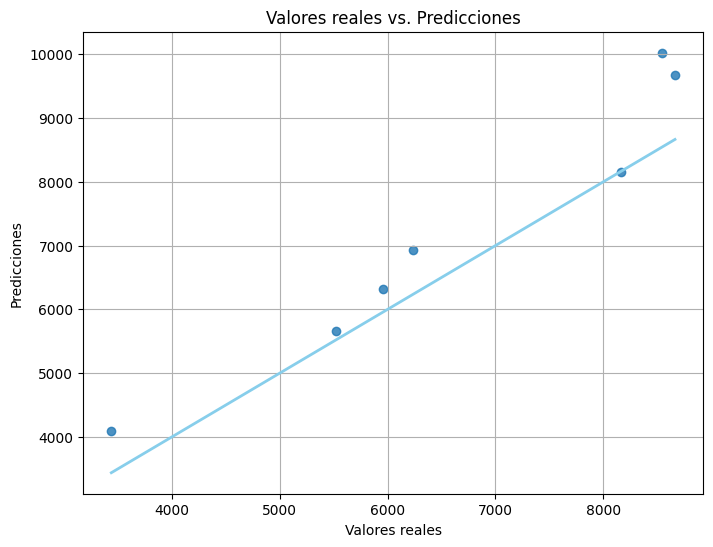

In [ ]:
# Crear una figura y ejes para el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.8)
plt.title('Valores reales vs. Predicciones')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.grid(True)

#Agregar linea de tendencia
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='-', color='skyblue', linewidth=2)
plt.show()


In [ ]:
print('Valor de la intersección')
print(regressor.intercept_.round(2))
print('Precisión de mi modelo')
print(regressor.score(X_test,y_test).round(2))

Valor de la intersección
2505.87
Precisión de mi modelo
0.81


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", round(mae, 2))

MAE: 541.0


El MSE es el promedio de los cuadrados de los errores entre las predicciones del modelo y los valores reales del conjunto de datos

##Hipotesis para el 2024:


1.   PBI 2024: el FMI estima una caida del 2,8%

2.   Precio del barril USD: Los analistas de JP Morgan Research asumen que los países de la OPEP+ ampliarán los recortes voluntarios de producción y exportación en 2024. Según estimaciones de los especialistas, las cotizaciones del Brent se situarán este año en unos 83 dólares por barril

3.   Inflación 2024: Bancos y consultoras reunidas en el Focus Economics pronostican en un estudio que la inflación de 2024 llegará a 219% en promedio anual



In [ ]:
# Nueva fila de datos para las hipótesis del año 2024
nueva_data = pd.DataFrame({'PBI USD': [604259724930],
                           'Inflacion%': [219],
                           'Precio promedio/barill USD OPEP': [83]})


In [ ]:
X = datos[['PBI USD','Inflacion%','Precio promedio/barill USD OPEP']]
y= datos['Total km3']

In [ ]:
# Predicción para la nueva fila de datos con regresion
prediccion_total_km3 = regressor.predict(nueva_data)

print("Predicción Total km3 para 2024:", prediccion_total_km3)

Predicción Total km3 para 2024: [9533.98315482]
